In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Caricamento Dati e Split Stratificato
Per garantire una valutazione impariziale dividiamo il dataset in:
* Training Set (80%): per l'addestramento dei modelli.
* Test Set (20%): esclusivamente per la valutazione finale.

Utilizziamo uno **Split Stratificato** (`stratify=y`) per mantenere le stesse proporzioni delle classi target in entrambi i set data la natura sbilanciata del dataset cinematografico.

In [10]:
df= pd.read_csv("../data/processed/dataset_features.csv")

X= df.drop(columns=['Target'])
y = df['Target']

#Train-Test Split stratificato
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Selezione degli Algoritmi

Abbiamo selezionato tre algoritmi con diverse caratteristiche per identificare il più adatto al problema:
1. **Logistic Regression**: Modello lineare utilizzato come *baseline*.
2. **Decision Tree**: Modello basato su regole decisionali, molto interpretabile.
3. **Random Forest**: Modello *ensemble* che combina più alberi per migliorare la capacità di generalizzazione e ridurre l'overfitting.

Per compensare lo sbilanciamento delle classi, utilizziamo il parametro `class_weight='balanced'`.

In [12]:
modelli = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
}

## Addestramento e Valutazione

Eseguiamo un ciclo di addestramento e predizione. Per ogni modello generiamo una **Confusion Matrix** per visualizzare non solo gli errori totali, ma anche quali classi vengono confuse tra loro.

--- CONFRONTO MODELLI DI MACHINE LEARNING ---



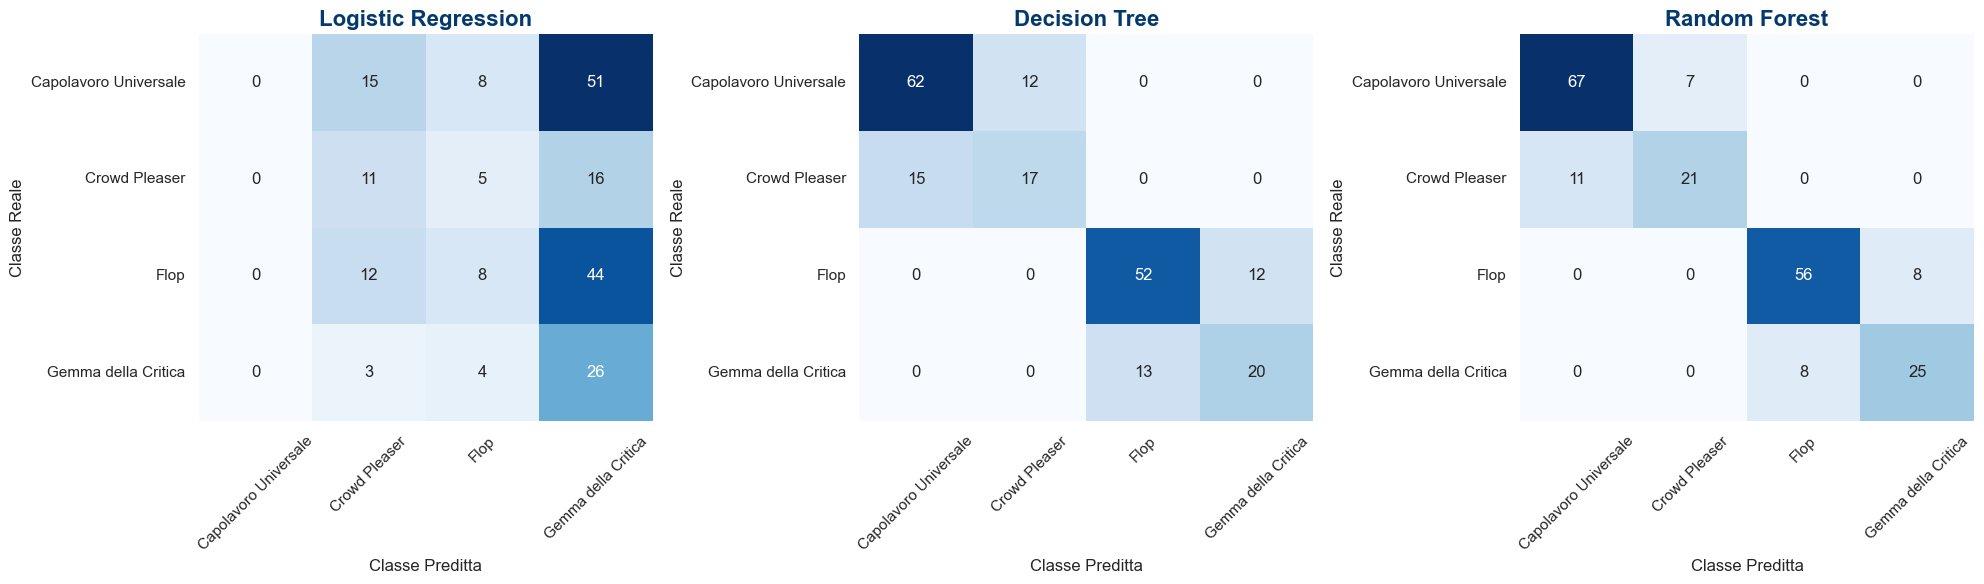

In [21]:
risultati = []
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.set_theme(style="white", palette="Blues_r")

print("--- CONFRONTO MODELLI DI MACHINE LEARNING ---\n")

for i, (nome_modello, modello) in enumerate(modelli.items()):
    #addestramenti
    modello.fit(X_train, y_train)

    #predizione
    y_pred= modello.predict(X_test)

    #estrazioni metriche (usiamo "macro" per fare la media equa tra le 4 classi)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    risultati.append({
        'Modello': nome_modello,
        'Accuracy': round(acc, 3),
        'Precision (Macro)': round(prec, 3),
        'Recall (Macro)': round(rec, 3),
        'F1-Score (Macro)': round(f1, 3)
    })

    cm = confusion_matrix(y_test, y_pred, labels=modello.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=modello.classes_, yticklabels=modello.classes_,
                ax=axes[i], cbar=False, annot_kws={"size": 12})

    axes[i].set_title(f'{nome_modello}', fontsize=16, fontweight='bold', color='#03396c')

    axes[i].set_ylabel('Classe Reale', fontsize=12)
    axes[i].set_xlabel('Classe Preditta', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('confronto_matrici_confusione.png', dpi=300)
plt.show()

## Analisi Comparativa delle Performance

I risultati mostrano una netta differenza tra gli approcci:

* **Random Forest (Best Model)**: Raggiunge l'accuratezza più elevata (**83.3%**) e un ottimo **F1-Score (0.804)**. La sua capacità di mediare tra più alberi lo rende il modello più affidabile per prevedere il successo dei film.
* **Decision Tree**: Segue con un'accuratezza del **74.4%**. Pur essendo solido, risulta meno preciso del Random Forest, probabilmente a causa di una leggera tendenza all'overfitting sui dati di training.
* **Logistic Regression**: Ottiene solo il **22.2%**. Questo risultato conferma che le relazioni tra variabili come budget, voti e successo non sono lineari e richiedono modelli più complessi basati su alberi.

In [22]:
df_risultati = pd.DataFrame(risultati)
df_risultati = df_risultati.sort_values(by='F1-Score (Macro)', ascending=False).reset_index(drop=True)

print("\n--- TABELLA COMPARATIVA DELLE METRICHE ---")
display(df_risultati)


--- TABELLA COMPARATIVA DELLE METRICHE ---


,Modello,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,Random Forest,0.833,0.810,0.799,0.804
1,Decision Tree,0.744,0.704,0.697,0.700
2,Logistic Regression,0.222,0.195,0.314,0.197



## Feature Importance (Random Forest)
_Cosa determina il successo?_

L'analisi dell'importanza delle variabili nel modello Random Forest rivela risultati molto interessanti:
* **Qualità Percepita**: L'**IMDB Rating (0.40)** e il **Metascore (0.25)** sono i fattori dominanti. Questo conferma che il giudizio del pubblico e della critica sono i pilastri fondamentali per definire la categoria di un film.
* **Fattori Strutturali**: L'anno di uscita (**Year, 0.15**), la durata (**Time minute, 0.12**) e gli incassi (**Box Office Collection, 0.10**) giocano un ruolo significativo ma secondario.
* **Ininfluenza del Genere**: I singoli generi (Drama, Horror, Comedy, ecc.) pesano meno dello **0.05**. Questo suggerisce che la qualità e il successo commerciale trascendono il genere di appartenenza; un film può diventare un "Capolavoro Universale" o un "Flop" indipendentemente dal fatto che sia una commedia o un horror.

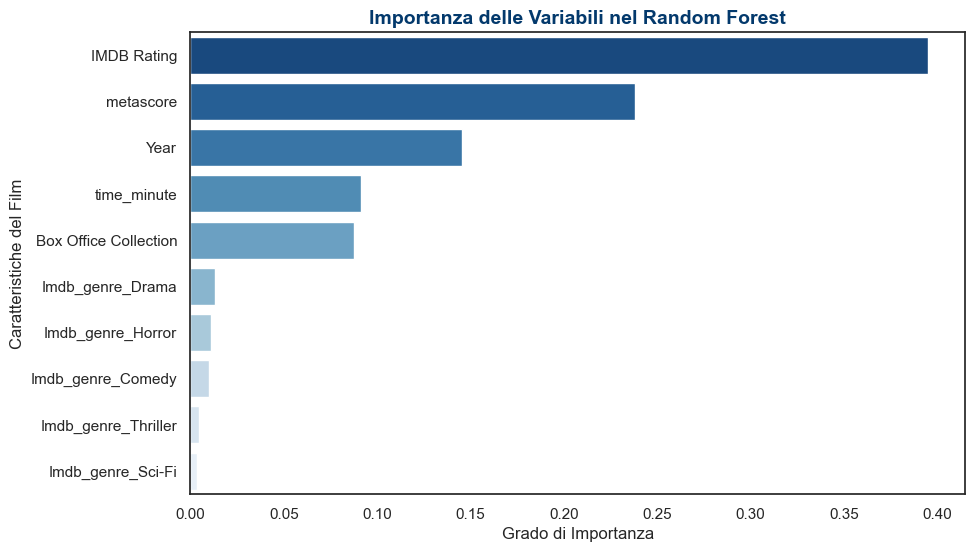

In [26]:
importances = modelli["Random Forest"].feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='Blues_r',
    hue='Feature',
    legend=False
)

plt.title('Importanza delle Variabili nel Random Forest', fontsize=14, fontweight='bold', color='#03396c')
plt.xlabel('Grado di Importanza')
plt.ylabel('Caratteristiche del Film')
plt.savefig('importanza_variabili.png', dpi=300)
plt.show()

## Conclusioni Finali
Il progetto ha dimostrato che è possibile prevedere con un'accuratezza dell'**83.3%** l'accoglienza di un film basandosi su dati strutturati. Il modello **Random Forest** si è rivelato il più efficace, specialmente nella gestione di classi divergenti. L'importanza data ai voti (IMDB e Metascore) rispetto ai generi sottolinea come, nel mercato cinematografico globale, il contenuto e il giudizio qualitativo siano predittori del successo molto più potenti rispetto alla semplice categoria tematica.